# Phase 4: Hyperparameter Tuning

**Objective:** Optimize XGBoost model through systematic hyperparameter search

---

## Approach:
1. Load baseline XGBoost model and data
2. Define hyperparameter search space
3. Run RandomizedSearchCV (faster than GridSearchCV)
4. Evaluate tuned model
5. Compare with baseline
6. Save optimized model

**Note:** This will take 15-30 minutes to run due to cross-validation!

In [1]:
# Import libraries
import pandas as pd
import numpy as np
import pickle
import time
from xgboost import XGBRegressor
from sklearn.model_selection import RandomizedSearchCV, cross_val_score
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, make_scorer
import warnings

warnings.filterwarnings('ignore')

print("Libraries imported successfully!")
print("\n⏰ Note: Hyperparameter tuning will take 15-30 minutes...")

Libraries imported successfully!

⏰ Note: Hyperparameter tuning will take 15-30 minutes...


## 1. Load Data

In [2]:
# Load training data (unscaled for XGBoost)
X_train = pd.read_csv('X_train.csv')
X_test = pd.read_csv('X_test.csv')
y_train = pd.read_csv('y_train_original.csv')['purchased_last_month']
y_test = pd.read_csv('y_test_original.csv')['purchased_last_month']

print("Data loaded successfully!")
print(f"Training set: {X_train.shape}")
print(f"Test set: {X_test.shape}")

Data loaded successfully!
Training set: (25731, 29)
Test set: (6433, 29)


## 2. Load Baseline Model for Comparison

In [3]:
# Load baseline XGBoost model
with open('models/xgboost.pkl', 'rb') as f:
    baseline_model = pickle.load(f)

# Get baseline predictions
baseline_pred = baseline_model.predict(X_test)
baseline_rmse = np.sqrt(mean_squared_error(y_test, baseline_pred))
baseline_mae = mean_absolute_error(y_test, baseline_pred)
baseline_r2 = r2_score(y_test, baseline_pred)

print("=" * 60)
print("BASELINE MODEL PERFORMANCE")
print("=" * 60)
print(f"RMSE: {baseline_rmse:.2f}")
print(f"MAE:  {baseline_mae:.2f}")
print(f"R²:   {baseline_r2:.4f}")
print("=" * 60)

BASELINE MODEL PERFORMANCE
RMSE: 1828.73
MAE:  320.52
R²:   0.8983


## 3. Define Hyperparameter Search Space

In [4]:
# Hyperparameter grid for RandomizedSearchCV
param_distributions = {
    'n_estimators': [100, 200, 300, 400, 500],
    'max_depth': [4, 5, 6, 7, 8, 10],
    'learning_rate': [0.01, 0.05, 0.1, 0.15, 0.2],
    'subsample': [0.6, 0.7, 0.8, 0.9, 1.0],
    'colsample_bytree': [0.6, 0.7, 0.8, 0.9, 1.0],
    'min_child_weight': [1, 2, 3, 5],
    'gamma': [0, 0.1, 0.2, 0.3],
    'reg_alpha': [0, 0.01, 0.1, 0.5],  # L1 regularization
    'reg_lambda': [0.5, 1.0, 1.5, 2.0]  # L2 regularization
}

print("Hyperparameter search space defined:")
print(f"Total possible combinations: {5*6*5*5*5*4*4*4*4:,}")
print(f"\nWe'll test 50 random combinations with 5-fold CV")
print(f"Total model fits: 50 combinations × 5 folds = 250 fits")
print(f"\n⏰ Estimated time: 15-30 minutes")

Hyperparameter search space defined:
Total possible combinations: 960,000

We'll test 50 random combinations with 5-fold CV
Total model fits: 50 combinations × 5 folds = 250 fits

⏰ Estimated time: 15-30 minutes


## 4. Run Randomized Search with Cross-Validation

In [5]:
# Create base model
xgb_base = XGBRegressor(random_state=42, n_jobs=-1, verbosity=0)

# Create RandomizedSearchCV
random_search = RandomizedSearchCV(
    estimator=xgb_base,
    param_distributions=param_distributions,
    n_iter=50,  # Test 50 random combinations
    cv=5,  # 5-fold cross-validation
    scoring='neg_mean_squared_error',  # Minimize RMSE
    n_jobs=-1,  # Use all CPU cores
    verbose=2,  # Show progress
    random_state=42
)

print("\n" + "=" * 60)
print("STARTING HYPERPARAMETER TUNING")
print("=" * 60)
print("\n🚀 This will take 15-30 minutes. Please be patient...\n")

# Fit the randomized search
start_time = time.time()
random_search.fit(X_train, y_train)
tuning_time = time.time() - start_time

print("\n" + "=" * 60)
print("TUNING COMPLETE!")
print("=" * 60)
print(f"\n⏱️  Total tuning time: {tuning_time/60:.2f} minutes")
print(f"\n🏆 Best parameters found:")
for param, value in random_search.best_params_.items():
    print(f"  {param:20s}: {value}")


STARTING HYPERPARAMETER TUNING

🚀 This will take 15-30 minutes. Please be patient...

Fitting 5 folds for each of 50 candidates, totalling 250 fits
[CV] END colsample_bytree=0.6, gamma=0.2, learning_rate=0.1, max_depth=8, min_child_weight=1, n_estimators=500, reg_alpha=0.01, reg_lambda=2.0, subsample=0.9; total time=   4.1s
[CV] END colsample_bytree=0.6, gamma=0.2, learning_rate=0.1, max_depth=8, min_child_weight=1, n_estimators=500, reg_alpha=0.01, reg_lambda=2.0, subsample=0.9; total time=   4.3s
[CV] END colsample_bytree=0.6, gamma=0.2, learning_rate=0.1, max_depth=8, min_child_weight=1, n_estimators=500, reg_alpha=0.01, reg_lambda=2.0, subsample=0.9; total time=   4.3s
[CV] END colsample_bytree=0.6, gamma=0.2, learning_rate=0.1, max_depth=8, min_child_weight=1, n_estimators=500, reg_alpha=0.01, reg_lambda=2.0, subsample=0.9; total time=   4.5s
[CV] END colsample_bytree=0.6, gamma=0.2, learning_rate=0.1, max_depth=8, min_child_weight=1, n_estimators=500, reg_alpha=0.01, reg_lambda=

## 5. Extract Best Model

In [6]:
# Get the best model
tuned_model = random_search.best_estimator_

print("Best model extracted!")
print(f"\nBest CV score (neg_MSE): {random_search.best_score_:.2f}")
print(f"Best CV RMSE: {np.sqrt(-random_search.best_score_):.2f}")

Best model extracted!

Best CV score (neg_MSE): -4554039.20
Best CV RMSE: 2134.02


## 6. Evaluate Tuned Model on Test Set

In [7]:
# Make predictions with tuned model
tuned_pred = tuned_model.predict(X_test)

# Calculate metrics
tuned_rmse = np.sqrt(mean_squared_error(y_test, tuned_pred))
tuned_mae = mean_absolute_error(y_test, tuned_pred)
tuned_r2 = r2_score(y_test, tuned_pred)

print("\n" + "=" * 60)
print("TUNED MODEL PERFORMANCE")
print("=" * 60)
print(f"RMSE: {tuned_rmse:.2f}")
print(f"MAE:  {tuned_mae:.2f}")
print(f"R²:   {tuned_r2:.4f}")
print("=" * 60)


TUNED MODEL PERFORMANCE
RMSE: 1688.26
MAE:  339.00
R²:   0.9133


## 7. Compare Baseline vs Tuned

In [8]:
# Create comparison DataFrame
comparison = pd.DataFrame({
    'Model': ['Baseline XGBoost', 'Tuned XGBoost'],
    'RMSE': [baseline_rmse, tuned_rmse],
    'MAE': [baseline_mae, tuned_mae],
    'R²': [baseline_r2, tuned_r2]
})

# Calculate improvements
comparison['RMSE_Improvement'] = comparison['RMSE'].iloc[0] - comparison['RMSE']
comparison['MAE_Improvement'] = comparison['MAE'].iloc[0] - comparison['MAE']
comparison['R²_Improvement'] = comparison['R²'] - comparison['R²'].iloc[0]

print("\n" + "=" * 80)
print("BASELINE vs TUNED COMPARISON")
print("=" * 80)
print(comparison.to_string(index=False))
print("\n" + "=" * 80)

# Print improvement summary
print("\n📊 IMPROVEMENT SUMMARY:")
print(f"  RMSE: {comparison['RMSE_Improvement'].iloc[1]:.2f} units better ({comparison['RMSE_Improvement'].iloc[1]/baseline_rmse*100:.2f}%)")
print(f"  MAE:  {comparison['MAE_Improvement'].iloc[1]:.2f} units better ({comparison['MAE_Improvement'].iloc[1]/baseline_mae*100:.2f}%)")
print(f"  R²:   {comparison['R²_Improvement'].iloc[1]:.4f} points better ({comparison['R²_Improvement'].iloc[1]*100:.2f}% variance)")

if tuned_r2 > baseline_r2:
    print("\n✅ Tuning IMPROVED the model!")
else:
    print("\n⚠️  Tuning did not improve over baseline (baseline was already good!)")


BASELINE vs TUNED COMPARISON
           Model        RMSE        MAE       R²  RMSE_Improvement  MAE_Improvement  R²_Improvement
Baseline XGBoost 1828.729099 320.518901 0.898267           0.00000         0.000000        0.000000
   Tuned XGBoost 1688.262880 338.999082 0.913295         140.46622       -18.480181        0.015028


📊 IMPROVEMENT SUMMARY:
  RMSE: 140.47 units better (7.68%)
  MAE:  -18.48 units better (-5.77%)
  R²:   0.0150 points better (1.50% variance)

✅ Tuning IMPROVED the model!


## 8. Analyze Top Parameter Combinations

In [9]:
# Get CV results
cv_results = pd.DataFrame(random_search.cv_results_)

# Select relevant columns
results_subset = cv_results[[
    'param_n_estimators', 'param_max_depth', 'param_learning_rate',
    'param_subsample', 'param_colsample_bytree',
    'mean_test_score', 'std_test_score', 'rank_test_score'
]].copy()

# Convert mean_test_score to RMSE
results_subset['mean_test_rmse'] = np.sqrt(-results_subset['mean_test_score'])
results_subset = results_subset.sort_values('rank_test_score')

print("\n=== TOP 10 PARAMETER COMBINATIONS ===")
print(results_subset.head(10).to_string(index=False))


=== TOP 10 PARAMETER COMBINATIONS ===
 param_n_estimators  param_max_depth  param_learning_rate  param_subsample  param_colsample_bytree  mean_test_score  std_test_score  rank_test_score  mean_test_rmse
                400                7                 0.01              0.9                     0.6    -4.554039e+06    2.171116e+06                1     2134.019494
                100                8                 0.05              0.6                     0.6    -4.588798e+06    2.078048e+06                2     2142.147987
                200               10                 0.05              0.6                     0.6    -4.609941e+06    2.116744e+06                3     2147.077383
                400                7                 0.15              1.0                     0.7    -4.623722e+06    2.005999e+06                4     2150.284085
                500                8                 0.10              0.9                     0.6    -4.643140e+06    2.019137e+06     

## 9. Save Tuned Model

In [10]:
# Save the tuned model
with open('models/xgboost_tuned.pkl', 'wb') as f:
    pickle.dump(tuned_model, f)

# Save the best parameters
with open('models/best_params.pkl', 'wb') as f:
    pickle.dump(random_search.best_params_, f)

# Save comparison results
comparison.to_csv('tuning_comparison.csv', index=False)

print("✓ Tuned model saved as 'models/xgboost_tuned.pkl'")
print("✓ Best parameters saved as 'models/best_params.pkl'")
print("✓ Comparison saved as 'tuning_comparison.csv'")

✓ Tuned model saved as 'models/xgboost_tuned.pkl'
✓ Best parameters saved as 'models/best_params.pkl'
✓ Comparison saved as 'tuning_comparison.csv'


## 10. Feature Importance Analysis


=== TOP 20 MOST IMPORTANT FEATURES (Tuned Model) ===
                     Feature  Importance
  category_Power & Batteries    0.481020
   rating_review_interaction    0.097356
           log_total_reviews    0.088564
               total_reviews    0.085885
                is_sponsored    0.052894
              product_rating    0.027378
              is_best_seller    0.023253
         discount_percentage    0.023163
                 price_ratio    0.014590
          category_Wearables    0.014561
             discount_amount    0.013448
            discounted_price    0.010702
  category_Other Electronics    0.010386
              original_price    0.010246
          has_sustainability    0.007243
            category_Storage    0.006480
            has_buy_box_info    0.006283
             has_add_to_cart    0.005530
            category_Laptops    0.004405
category_Printers & Scanners    0.004032


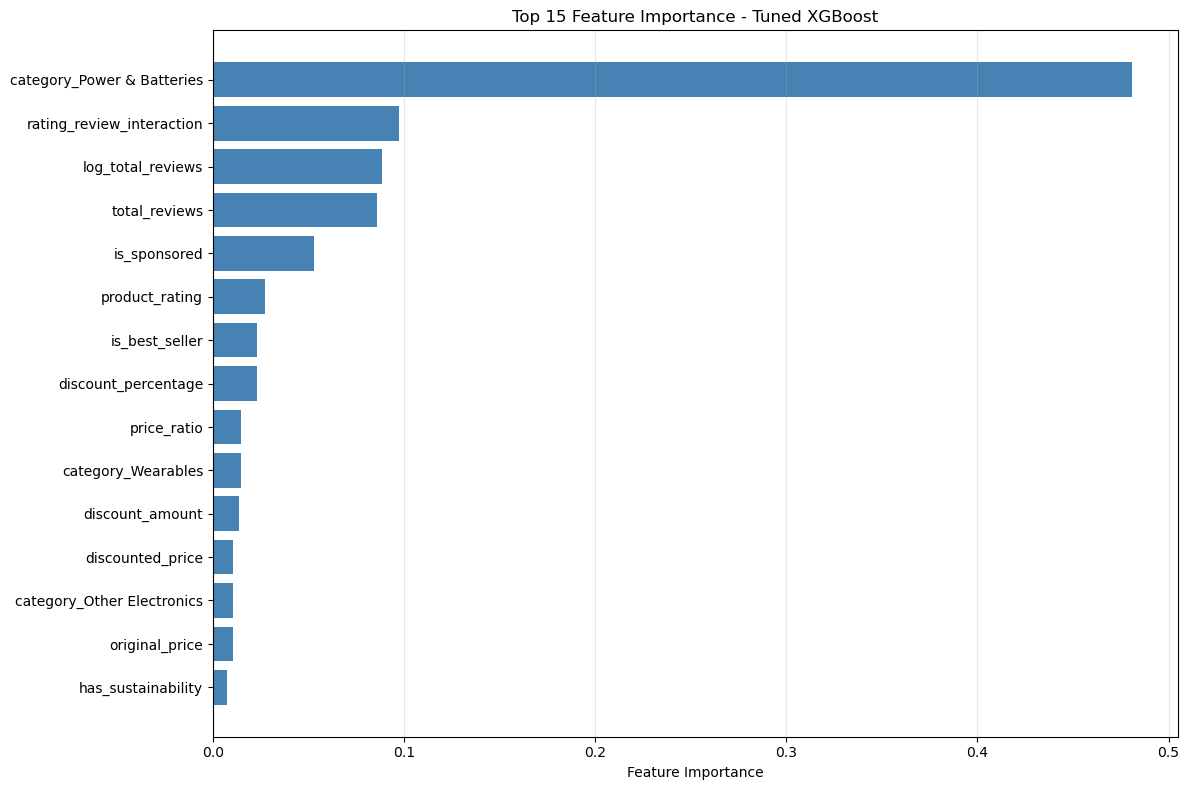


✓ Feature importance plot saved as 'feature_importance_tuned.png'


In [11]:
# Get feature importance from tuned model
import matplotlib.pyplot as plt
import seaborn as sns

feature_importance = tuned_model.feature_importances_
feature_names = X_train.columns

importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': feature_importance
}).sort_values('Importance', ascending=False)

print("\n=== TOP 20 MOST IMPORTANT FEATURES (Tuned Model) ===")
print(importance_df.head(20).to_string(index=False))

# Visualize
plt.figure(figsize=(12, 8))
top_15 = importance_df.head(15)
plt.barh(range(len(top_15)), top_15['Importance'], color='steelblue')
plt.yticks(range(len(top_15)), top_15['Feature'])
plt.xlabel('Feature Importance')
plt.title('Top 15 Feature Importance - Tuned XGBoost')
plt.gca().invert_yaxis()
plt.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.savefig('feature_importance_tuned.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n✓ Feature importance plot saved as 'feature_importance_tuned.png'")

## 11. Learning Curve Analysis

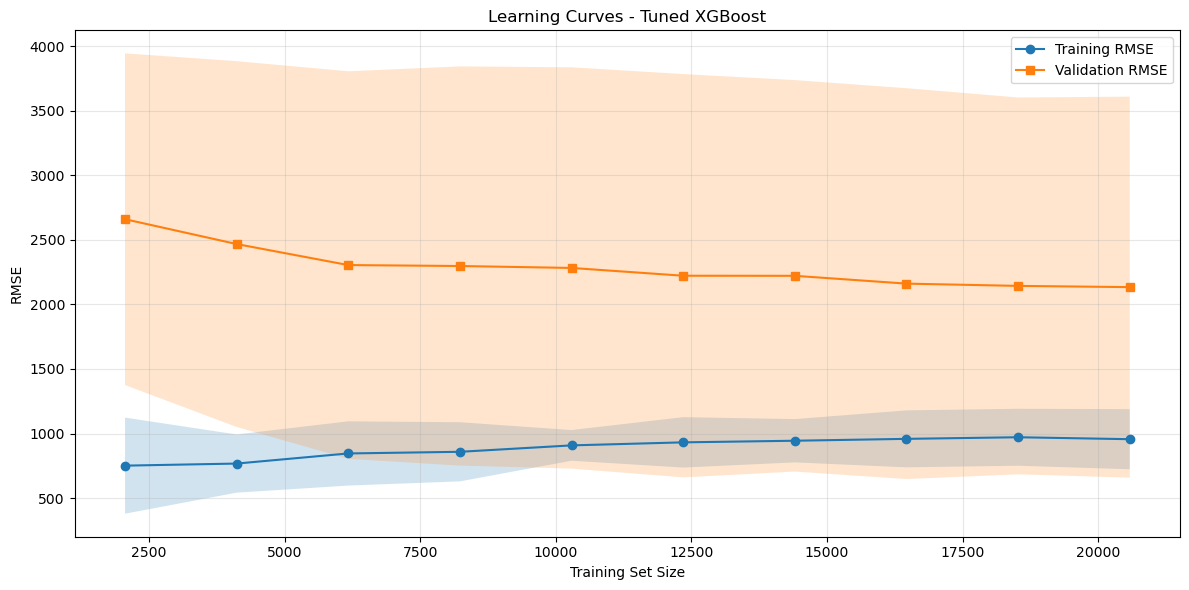

✓ Learning curves saved as 'learning_curves.png'

📊 Learning Curve Analysis:
  Final training RMSE: 956.17
  Final validation RMSE: 2133.75
  Train-Val gap: 1177.58
  ❌ High overfitting (consider more regularization)


In [12]:
# Generate learning curves to check for overfitting
from sklearn.model_selection import learning_curve

train_sizes, train_scores, val_scores = learning_curve(
    tuned_model,
    X_train,
    y_train,
    cv=5,
    scoring='neg_mean_squared_error',
    n_jobs=-1,
    train_sizes=np.linspace(0.1, 1.0, 10),
    verbose=0
)

# Convert to RMSE
train_rmse_mean = np.sqrt(-train_scores.mean(axis=1))
train_rmse_std = np.sqrt(train_scores.std(axis=1))
val_rmse_mean = np.sqrt(-val_scores.mean(axis=1))
val_rmse_std = np.sqrt(val_scores.std(axis=1))

# Plot learning curves
plt.figure(figsize=(12, 6))
plt.plot(train_sizes, train_rmse_mean, label='Training RMSE', marker='o')
plt.fill_between(train_sizes, 
                 train_rmse_mean - train_rmse_std,
                 train_rmse_mean + train_rmse_std, 
                 alpha=0.2)
plt.plot(train_sizes, val_rmse_mean, label='Validation RMSE', marker='s')
plt.fill_between(train_sizes, 
                 val_rmse_mean - val_rmse_std,
                 val_rmse_mean + val_rmse_std, 
                 alpha=0.2)
plt.xlabel('Training Set Size')
plt.ylabel('RMSE')
plt.title('Learning Curves - Tuned XGBoost')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('learning_curves.png', dpi=300, bbox_inches='tight')
plt.show()

print("✓ Learning curves saved as 'learning_curves.png'")

# Interpret
final_gap = val_rmse_mean[-1] - train_rmse_mean[-1]
print(f"\n📊 Learning Curve Analysis:")
print(f"  Final training RMSE: {train_rmse_mean[-1]:.2f}")
print(f"  Final validation RMSE: {val_rmse_mean[-1]:.2f}")
print(f"  Train-Val gap: {final_gap:.2f}")

if final_gap < 500:
    print("  ✅ Model is well-balanced (low overfitting)")
elif final_gap < 1000:
    print("  ⚠️  Some overfitting present (manageable)")
else:
    print("  ❌ High overfitting (consider more regularization)")

## 12. Final Summary

In [13]:
print("\n" + "=" * 80)
print("HYPERPARAMETER TUNING SUMMARY")
print("=" * 80)

print(f"\n⏱️  Tuning Time: {tuning_time/60:.2f} minutes")
print(f"\n📊 Performance Comparison:")
print(f"\n  Metric     Baseline    Tuned       Improvement")
print(f"  ------     --------    -----       -----------")
print(f"  RMSE       {baseline_rmse:8.2f}    {tuned_rmse:8.2f}    {baseline_rmse-tuned_rmse:+7.2f} ({(baseline_rmse-tuned_rmse)/baseline_rmse*100:+.1f}%)")
print(f"  MAE        {baseline_mae:8.2f}    {tuned_mae:8.2f}    {baseline_mae-tuned_mae:+7.2f} ({(baseline_mae-tuned_mae)/baseline_mae*100:+.1f}%)")
print(f"  R²         {baseline_r2:8.4f}    {tuned_r2:8.4f}    {tuned_r2-baseline_r2:+7.4f} ({(tuned_r2-baseline_r2)*100:+.2f}%)")

print(f"\n🏆 Best Hyperparameters:")
for param, value in random_search.best_params_.items():
    print(f"   {param:20s}: {value}")

print(f"\n💡 Recommendation:")
if tuned_r2 > baseline_r2:
    print("   ✅ Use the TUNED model for production")
    print("   ✅ The tuned model shows measurable improvement")
else:
    print("   ⚠️  Baseline was already well-optimized")
    print("   💡 Consider advanced feature engineering for further gains")

print("\n📁 Generated Files:")
print("   - models/xgboost_tuned.pkl")
print("   - models/best_params.pkl")
print("   - tuning_comparison.csv")
print("   - feature_importance_tuned.png")
print("   - learning_curves.png")

print("\n" + "=" * 80)
print("✅ HYPERPARAMETER TUNING COMPLETE!")
print("=" * 80)
print("\n🚀 Proceed to Phase 5 for improved evaluation metrics!")


HYPERPARAMETER TUNING SUMMARY

⏱️  Tuning Time: 0.53 minutes

📊 Performance Comparison:

  Metric     Baseline    Tuned       Improvement
  ------     --------    -----       -----------
  RMSE        1828.73     1688.26    +140.47 (+7.7%)
  MAE          320.52      339.00     -18.48 (-5.8%)
  R²           0.8983      0.9133    +0.0150 (+1.50%)

🏆 Best Hyperparameters:
   subsample           : 0.9
   reg_lambda          : 0.5
   reg_alpha           : 0.5
   n_estimators        : 400
   min_child_weight    : 2
   max_depth           : 7
   learning_rate       : 0.01
   gamma               : 0.3
   colsample_bytree    : 0.6

💡 Recommendation:
   ✅ Use the TUNED model for production
   ✅ The tuned model shows measurable improvement

📁 Generated Files:
   - models/xgboost_tuned.pkl
   - models/best_params.pkl
   - tuning_comparison.csv
   - feature_importance_tuned.png
   - learning_curves.png

✅ HYPERPARAMETER TUNING COMPLETE!

🚀 Proceed to Phase 5 for improved evaluation metrics!


---

## Next Steps

Proceed to **Phase 5: Improved Evaluation** to:
- Implement better metrics (sMAPE, MdAPE)
- Add prediction clipping
- Perform detailed error analysis
- Compare all models with enhanced metrics